In [210]:
import requests
import datetime
from elasticsearch import Elasticsearch
from pandas.io.json import json_normalize
import pandas as pd
import numpy as np
import progressbar
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
def to_date(s):
    dt = datetime.datetime.utcfromtimestamp(s / 1e3)
    return dt.strftime("%Y-%m-%d")

def to_df(res):                                                                       #时间调整
    test_df = json_normalize(res['aggregations']['my_buckets']['buckets'])
    test_df.columns = map(lambda x: x.split('key.')[-1] if x.startswith('key.') else x, list(test_df.columns))
    #test_df['日期'] = test_df['日期'].apply(to_date)
    #test_df['日期'] = pd.to_datetime(test_df['日期'])
    #test_df['current_vip_created']= test_df['current_vip_created'].apply(to_date)
    #test_df['current_vip_created']= pd.to_datetime(test_df['current_vip_created'])
    #test_df['购买列表']= test_df['购买列表'].apply(to_date)
    #test_df['购买列表']= pd.to_datetime(test_df['购买列表'])
    return test_df

def get_result(dsl,index,doc_type):
    es = Elasticsearch(['http://172.18.198.27:9200/'], timeout=30)
    res = es.search(index=index, doc_type=doc_type, body=dsl,
                        _source=False, explain=False, track_scores=False, track_total_hits=False, size=0,
                        search_type='query_then_fetch')
    df = to_df(res)
    return df

dsl1 = {'aggs': {'my_buckets': {'composite': {'size': 9999999,
                                       'sources': [
                                                   {'id': {'terms': {'field': 'id'}}},

                                                  ]}}},
 'query': {'bool': {'must': [{'range': {'first_vip_created': {'format': 'yyyy-MM-dd',
                                                              'gte': '2019-05-23',
                                                              'lte': '2019-05-23',
                                                              'time_zone': '+00:00'}}}]}}}

In [211]:
df1 = get_result(dsl1,'es_user_table','user')

In [212]:
df1['id'].nunique()

3841

In [213]:
dsl11 = {
        'aggs': {'my_buckets': {'aggregations': {'打开(Visitor)': {'cardinality': {'field': 'session_id', 'precision_threshold': 100}}},
                         'composite': {'size': 9999999,
                                       'sources': [{"用户ID": {"terms": {"field": 'user_id'}}},
                                           #{'日期': {'date_histogram': {'field': 'created',
                                           #                                   'interval': '1m',
                                           #                                   'time_zone': '+08:00'}}}
                                       ]}}},
         'query': {'bool': {'must': [#{'query_string': {'query': "group_category_name='早餐档'"}},
                                     {'range': {'created': {'format': 'yyyy-MM-dd',
                                                    'gte': '2019-05-24',
                                                    'lte': '2019-05-30',
                                                    'time_zone': '+08:00'}}},
                             {'terms': {'app_name': ['vip-mini']}},
                            # {'terms': {'event_name': ['index', '首页']}},
                             {'terms': {'user_id': df1['id'].tolist()}},
                            # {'terms': {'event_type': ['event']}}
                        ]}}}
es11 = Elasticsearch(['http://172.18.198.27:9200/'], timeout=30)
res11 = es11.search(index='shop_pv_event', doc_type='pv_event', body=dsl11,
                _source=False, explain=False, track_scores=False, track_total_hits=False, size=0,
                search_type='query_then_fetch')
df11 = json_normalize(res11['aggregations']['my_buckets']['buckets'])
df11.columns = map(lambda x: x.split('key.')[-1] if x.startswith('key.') else x, list(df11.columns))
#df11['日期'] = df11['日期'].apply(to_date)
#df11['日期'] = pd.to_datetime(df11['日期'])

In [214]:
len(df11)

1119

In [215]:
df11.head()

,doc_count,用户ID,打开(Visitor).value
0,76,239985,5
1,7,264951,1
2,9,265739,2
3,15,306921,4
4,129,310608,3


In [216]:
df11['打开(Visitor).value'].max()

92

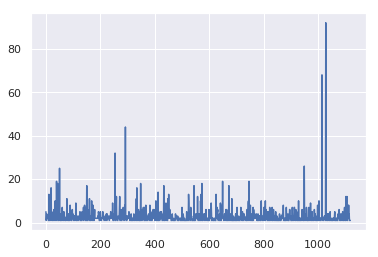

In [217]:
plt.plot(df11['打开(Visitor).value'])

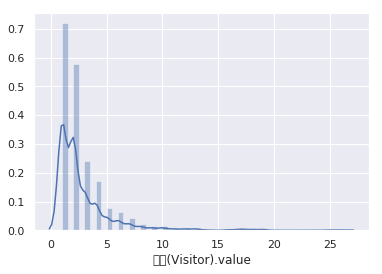

In [218]:
df_new=df11[df11['打开(Visitor).value']<=30]
sns.distplot(df_new['打开(Visitor).value'])

In [219]:
len(df_new)/len(df11)

0.9964253798033958

In [220]:
df_new=df_new.drop(['doc_count'],axis=1)
df_new.head()

,用户ID,打开(Visitor).value
0,239985,5
1,264951,1
2,265739,2
3,306921,4
4,310608,3


In [221]:
def get_visit_list(s):
    data={}
    data['visit_list'] = s['用户ID'].tolist()
    return pd.Series(data)

df_list = df_new.groupby('打开(Visitor).value').apply(get_visit_list).reset_index()
df_list.head()

,打开(Visitor).value,visit_list
0,1,"[264951, 326640, 327622, 329670, 332229, 39732..."
1,2,"[265739, 319627, 325337, 386187, 487350, 51702..."
2,3,"[310608, 311700, 322007, 580419, 654158, 67583..."
3,4,"[306921, 420907, 429444, 438060, 552034, 55301..."
4,5,"[239985, 345136, 356005, 520856, 525396, 65010..."


In [222]:
dsl_all = {
        'aggs': {'my_buckets': {'aggregations': {'打开(Visitor)': {'cardinality': {'field': 'session_id', 'precision_threshold': 100}}},
                         'composite': {'size': 9999999,
                                       'sources': [{"用户ID": {"terms": {"field": 'user_id'}}},
                                           #{'日期': {'date_histogram': {'field': 'created',
                                           #                                   'interval': '1m',
                                           #                                   'time_zone': '+08:00'}}}
                                       ]}}},
         'query': {'bool': {'must': [#{'query_string': {'query': "group_category_name='早餐档'"}},
                                     {'range': {'created': {'format': 'yyyy-MM-dd',
                                                    'gte': '2019-05-31',
                                                    'lte': '2019-06-06',
                                                    'time_zone': '+08:00'}}},
                             {'terms': {'app_name': ['vip-mini']}},
                            # {'terms': {'event_name': ['index', '首页']}},
                            # {'terms': {'user_id': df1['id'].tolist()}},
                            # {'terms': {'event_type': ['event']}}
                        ]}}}
es_all = Elasticsearch(['http://172.18.198.27:9200/'], timeout=30)
res_all = es_all.search(index='shop_pv_event', doc_type='pv_event', body=dsl_all,
                _source=False, explain=False, track_scores=False, track_total_hits=False, size=0,
                search_type='query_then_fetch')
df_all = json_normalize(res_all['aggregations']['my_buckets']['buckets'])
df_all.columns = map(lambda x: x.split('key.')[-1] if x.startswith('key.') else x, list(df_all.columns))

In [223]:
new_visit_list = df_all['用户ID'].tolist()    #新一个月的用户访问列表

In [224]:
bar = progressbar
per_rem = []
for i in bar.progressbar(range(len(df_list))):
    list_together = list(set(df_list.iloc[i]['visit_list']).intersection(set(new_visit_list)))
    per_rem.append(len(list_together)/len(df_list.iloc[i]['visit_list']))
                         
df_list['留存率'] = per_rem                   
                         
                         

100% (20 of 20) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


In [225]:
len(df_list.iloc[0]['visit_list'])

401

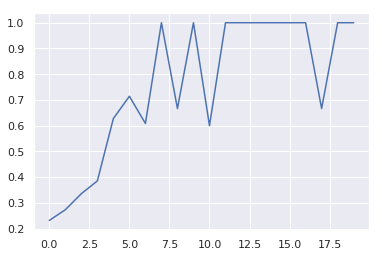

In [226]:
plt.plot(df_list['留存率'])

In [237]:
bar = progressbar                                                       #分类依据
active_list,dead_list = [],[]
for i in bar.progressbar(range(len(df11))):
    if df11.iloc[i]['打开(Visitor).value']<5:
        dead_list.append(df11.iloc[i]['用户ID'])
    else:
        active_list.append(df11.iloc[i]['用户ID'])

100% (1119 of 1119) |####################| Elapsed Time: 0:00:00 Time:  0:00:00


In [238]:
len(dead_list)

953

In [239]:
len(active_list)

166

In [307]:
dsl_dead = {
        'aggs': {'my_buckets': {'aggregations': {'打开(Visitor)': {'cardinality': {'field': 'session_id', 'precision_threshold': 100}}},
                         'composite': {'size': 9999999,
                                       'sources': [#{"用户ID": {"terms": {"field": 'user_id'}}},
                                           {'日期': {'date_histogram': {'field': 'created',
                                                                              'interval': '1d',
                                                                              'time_zone': '+08:00'}}}
                                       ]}}},
         'query': {'bool': {'must': [{'range': {'created': {'format': 'yyyy-MM-dd',
                                                    'gte': '2019-05-24',
                                                    'lte': '2019-06-06',
                                                    'time_zone': '+08:00'}}},
                             {'terms': {'app_name': ['vip-mini']}},
                             {'terms': {'user_id': dead_list}},
                        ]}}}
es_dead = Elasticsearch(['http://172.18.198.27:9200/'], timeout=30)
res_dead = es_dead.search(index='shop_pv_event', doc_type='pv_event', body=dsl_dead,
                _source=False, explain=False, track_scores=False, track_total_hits=False, size=0,
                search_type='query_then_fetch')
df_dead = json_normalize(res_dead['aggregations']['my_buckets']['buckets'])
df_dead.columns = map(lambda x: x.split('key.')[-1] if x.startswith('key.') else x, list(df_dead.columns))
df_dead['日期'] = df_dead['日期'].apply(to_date)
df_dead['日期'] = pd.to_datetime(df_dead['日期'])

In [308]:
df_dead.head()

,doc_count,日期,打开(Visitor).value
0,5451,2019-05-23,556
1,3934,2019-05-24,337
2,2618,2019-05-25,273
3,2255,2019-05-26,258
4,1856,2019-05-27,243


In [309]:
bar = progressbar
dead_per = []
for i in bar.progressbar(range(len(df_dead))):
    dead_per.append(df_dead.iloc[i]['打开(Visitor).value']/len(dead_list))
df_dead['占比']= dead_per

100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


In [310]:
dsl_active = {
        'aggs': {'my_buckets': {'aggregations': {'打开(Visitor)': {'cardinality': {'field': 'session_id', 'precision_threshold': 100}}},
                         'composite': {'size': 9999999,
                                       'sources': [#{"用户ID": {"terms": {"field": 'user_id'}}},
                                           {'日期': {'date_histogram': {'field': 'created',
                                                                              'interval': '1d',
                                                                              'time_zone': '+08:00'}}}
                                       ]}}},
         'query': {'bool': {'must': [{'range': {'created': {'format': 'yyyy-MM-dd',
                                                    'gte': '2019-05-24',
                                                    'lte': '2019-06-06',
                                                    'time_zone': '+08:00'}}},
                             {'terms': {'app_name': ['vip-mini']}},
                             {'terms': {'user_id': active_list}},
                        ]}}}
es_active = Elasticsearch(['http://172.18.198.27:9200/'], timeout=30)
res_active = es_active.search(index='shop_pv_event', doc_type='pv_event', body=dsl_active,
                _source=False, explain=False, track_scores=False, track_total_hits=False, size=0,
                search_type='query_then_fetch')
df_active = json_normalize(res_active['aggregations']['my_buckets']['buckets'])
df_active.columns = map(lambda x: x.split('key.')[-1] if x.startswith('key.') else x, list(df_active.columns))
df_active['日期'] = df_active['日期'].apply(to_date)
df_active['日期'] = pd.to_datetime(df_active['日期'])

In [311]:
df_active.head()

,doc_count,日期,打开(Visitor).value
0,4427,2019-05-23,352
1,4119,2019-05-24,303
2,2967,2019-05-25,243
3,3484,2019-05-26,248
4,3048,2019-05-27,226


In [312]:
bar = progressbar
active_per = []
for i in bar.progressbar(range(len(df_active))):
    active_per.append(df_active.iloc[i]['打开(Visitor).value']/len(active_list))
df_active['占比']= active_per

100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


(array([737202., 737204., 737206., 737208., 737210., 737211., 737213.,
        737215.]), <a list of 8 Text xticklabel objects>)

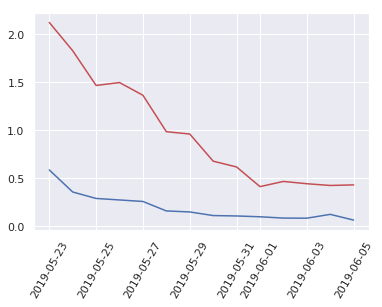

In [313]:
plt.plot(df_active['日期'],df_active['占比'],'r-',
        df_dead['日期'],df_dead['占比'],'b-')
plt.xticks(rotation='60')

页面浏览

In [265]:
dsl_de = {'query': {'bool': {'must': 
                                    [{'range': {'created': {'gte': '2019-05-24', 
                                                            'lte': '2019-05-30', 
                                                            'format': 'yyyy-MM-dd', 'time_zone': '+08:00'}}}, 
                                     {'terms':{'user_id': dead_list}},
                                    ]}}, 
         'aggs': {'my_buckets': {'composite': {'size': 9999999, 'sources': [
                                                    #{'日期': {'date_histogram': {'field': 'created', 'interval': '1d', 'time_zone': '+08:00'}}},
                                                     {'current_page': {'terms': {'field': 'current_page'}}}, 
                                                                           ]}, 
                                }}}
es_de = Elasticsearch(['http://172.18.198.27:9200/'], timeout=30)
res_de = es_de.search(index='shop_pv_event', doc_type='pv_event', body=dsl_de,
                _source=False, explain=False, track_scores=False, track_total_hits=False, size=0,
                search_type='query_then_fetch')
df_de = json_normalize(res_de['aggregations']['my_buckets']['buckets'])
df_de.columns = map(lambda x: x.split('key.')[-1] if x.startswith('key.') else x, list(df_de.columns))
#df_de['日期'] = df_de['日期'].apply(to_date)
#df_de['日期'] = pd.to_datetime(df_de['日期'])

In [266]:
dsl_ac = {'query': {'bool': {'must': 
                                    [{'range': {'created': {'gte': '2019-05-24', 
                                                            'lte': '2019-05-30', 
                                                            'format': 'yyyy-MM-dd', 'time_zone': '+08:00'}}}, 
                                     {'terms':{'user_id':active_list}},
                                    ]}}, 
         'aggs': {'my_buckets': {'composite': {'size': 9999999, 'sources': [
                                             # {'日期': {'date_histogram': {'field': 'created', 'interval': '1d', 'time_zone': '+08:00'}}},
                                              {'current_page': {'terms': {'field': 'current_page'}}}, 
                                                                           ]}, 
                                }}}
es_ac = Elasticsearch(['http://172.18.198.27:9200/'], timeout=30)
res_ac = es_ac.search(index='shop_pv_event', doc_type='pv_event', body=dsl_ac,
                _source=False, explain=False, track_scores=False, track_total_hits=False, size=0,
                search_type='query_then_fetch')
df_ac = json_normalize(res_ac['aggregations']['my_buckets']['buckets'])
df_ac.columns = map(lambda x: x.split('key.')[-1] if x.startswith('key.') else x, list(df_ac.columns))
#df_ac['日期'] = df_ac['日期'].apply(to_date)
#df_ac['日期'] = pd.to_datetime(df_ac['日期'])

In [267]:
df_de.head()

,doc_count,current_page
0,11,
1,114,TOP榜单
2,667,discount
3,609,index
4,14,packets


In [276]:
df_de_ten = df_de.sort_values('doc_count',ascending=False)[0:10]

In [277]:
df_ac_ten = df_ac.sort_values('doc_count',ascending=False)[0:10]

In [286]:
df_de_ten

,doc_count,current_page
39,5968,首页
19,3858,商家详情
7,1721,webview
30,1255,支付页
12,972,五折日历列表页
36,803,键盘页
38,783,领取小黑卡
37,766,附近优惠
2,667,discount
3,609,index


In [282]:
df_ac_ten

,doc_count,current_page
37,6865,首页
16,5967,商家详情
10,1761,五折日历列表页
24,1241,我的收益
7,1218,webview
28,758,支付页
35,727,附近优惠
2,542,discount
34,520,键盘页
36,487,领取小黑卡


开通来源  #first_vip_plan_id

In [303]:
dsl_source = {'aggs': {'my_buckets': {'composite': {'size': 9999999,
                                       'sources': [{'会员由来': {'terms': {'field': 'first_vip_plan_id'}}}
                                                  # {'id': {'terms': {'field': 'id'}}},     
                                                  ]}}},
                             'query': {'bool': {'must': [{'terms':{'id': active_list}},
                            ]}}}
es_source = Elasticsearch(['http://172.18.198.27:9200/'], timeout=30)
res_source = es_source.search(index='es_user_table', doc_type='user', body=dsl_source,
                        _source=False, explain=False, track_scores=False, track_total_hits=False, size=0,
                        search_type='query_then_fetch')
df_source = json_normalize(res_source['aggregations']['my_buckets']['buckets'])
df_source.columns = map(lambda x: x.split('key.')[-1] if x.startswith('key.') else x, list(df_source.columns))

In [304]:
df_source.head()

,doc_count,会员由来
0,155,分销渠道
1,11,原价购买


In [305]:
dsl_source = {'aggs': {'my_buckets': {'composite': {'size': 9999999,
                                       'sources': [{'会员由来': {'terms': {'field': 'first_vip_plan_id'}}}
                                                  # {'id': {'terms': {'field': 'id'}}},     
                                                  ]}}},
                             'query': {'bool': {'must': [{'terms':{'id': dead_list}},
                            ]}}}
es_source = Elasticsearch(['http://172.18.198.27:9200/'], timeout=30)
res_source = es_source.search(index='es_user_table', doc_type='user', body=dsl_source,
                        _source=False, explain=False, track_scores=False, track_total_hits=False, size=0,
                        search_type='query_then_fetch')
df_source = json_normalize(res_source['aggregations']['my_buckets']['buckets'])
df_source.columns = map(lambda x: x.split('key.')[-1] if x.startswith('key.') else x, list(df_source.columns))

In [306]:
df_source.head()

,doc_count,会员由来
0,930,分销渠道
1,12,前置购买
2,11,原价购买


In [370]:
dsl_de = {'query': {'bool': {'must': 
                                    [{'range': {'created': {'gte': '2019-05-24', 
                                                            'lte': '2019-05-30', 
                                                            'format': 'yyyy-MM-dd', 'time_zone': '+08:00'}}}, 
                                        {'terms':{'user_id': dead_list}},
                                    ]}}, 
         'aggs': {'my_buckets': {'composite': {'size': 9999999, 'sources': [
                                                    #{'日期': {'date_histogram': {'field': 'created', 'interval': '1d', 'time_zone': '+08:00'}}},
                                                     {'行为': {'terms': {'field': 'event_name'}}}, 
                                                                           ]}, 
                                }}}
es_de = Elasticsearch(['http://172.18.198.27:9200/'], timeout=30)
res_de = es_de.search(index='shop_pv_event', doc_type='pv_event', body=dsl_de,
                _source=False, explain=False, track_scores=False, track_total_hits=False, size=0,
                search_type='query_then_fetch')
df_de = json_normalize(res_de['aggregations']['my_buckets']['buckets'])
df_de.columns = map(lambda x: x.split('key.')[-1] if x.startswith('key.') else x, list(df_de.columns))

In [371]:
df_de=df_de.sort_values('doc_count',ascending=False).reset_index()
dsl_ac = {'query': {'bool': {'must': 
                                    [{'range': {'created': {'gte': '2019-05-24', 
                                                            'lte': '2019-05-30', 
                                                            'format': 'yyyy-MM-dd', 'time_zone': '+08:00'}}}, 
                                        {'terms':{'user_id': active_list}},
                                    ]}}, 
         'aggs': {'my_buckets': {'composite': {'size': 9999999, 'sources': [
                                                    #{'日期': {'date_histogram': {'field': 'created', 'interval': '1d', 'time_zone': '+08:00'}}},
                                                     {'行为': {'terms': {'field': 'event_name'}}}, 
                                                                           ]}, 
                                }}}
es_ac = Elasticsearch(['http://172.18.198.27:9200/'], timeout=30)
res_ac = es_ac.search(index='shop_pv_event', doc_type='pv_event', body=dsl_ac,
                _source=False, explain=False, track_scores=False, track_total_hits=False, size=0,
                search_type='query_then_fetch')
df_ac = json_normalize(res_ac['aggregations']['my_buckets']['buckets'])
df_ac.columns = map(lambda x: x.split('key.')[-1] if x.startswith('key.') else x, list(df_ac.columns))
df_ac=df_ac.sort_values('doc_count',ascending=False).reset_index()

In [372]:
df_de['doc_count']=df_de['doc_count']/len(dead_list)
df_ac['doc_count']=df_ac['doc_count']/len(active_list)
df_de=df_de[0:10]
df_de['活doc_count']=df_ac['doc_count'][0:10].tolist()
df_de['活行为']=df_ac['行为'][0:10].tolist()

In [373]:
df_de.head(10)

,index,doc_count,行为,活doc_count,活行为
0,69,4.803778,获取定位,31.831325,获取定位
1,16,1.668416,webview,11.487952,商家详情
2,88,1.545645,首页,11.174699,进入门店详情
3,61,1.367261,用户站点,9.174699,首页
4,33,1.323190,商家详情,8.295181,用户站点
5,80,1.299056,进入门店详情,7.066265,返回
6,73,0.924449,返回,6.777108,webview
7,84,0.825813,键盘页,4.566265,查看大图
8,51,0.688353,支付页,4.343373,我的收益
9,50,0.648478,支付成功,3.457831,进入分销_button


In [385]:
dsl = {'query': {'bool': {'must': 
                                    [{'range': {'created': {'gte': '2019-05-24', 
                                                            'lte': '2019-06-06', 
                                                            'format': 'yyyy-MM-dd', 'time_zone': '+08:00'}}}, 
                                        {'terms':{'user_id': active_list}},
                                        #{'terms':{'user_id': dead_list}},
                                        {'terms': {'event_name': ['我的收益']}}
                                    ]}}, 
         'aggs': {'my_buckets': {'composite': {'size': 9999999, 'sources': [
                                                    {'日期': {'date_histogram': {'field': 'created', 'interval': '1d', 'time_zone': '+08:00'}}},
                                                     #{'行为': {'terms': {'field': 'event_name'}}}, 
                                                                           ]}, 
                                }}}
es_sy = Elasticsearch(['http://172.18.198.27:9200/'], timeout=30)
res_sy = es_sy.search(index='shop_pv_event', doc_type='pv_event', body=dsl,
                _source=False, explain=False, track_scores=False, track_total_hits=False, size=0,
                search_type='query_then_fetch')
df_sy = json_normalize(res_sy['aggregations']['my_buckets']['buckets'])
df_sy.columns = map(lambda x: x.split('key.')[-1] if x.startswith('key.') else x, list(df_sy.columns))
df_sy['日期'] = df_sy['日期'].apply(to_date)
df_sy['日期'] = pd.to_datetime(df_sy['日期'])
df_sy['doc_count']=df_sy['doc_count']/len(active_list)

In [386]:
dsl = {'query': {'bool': {'must': 
                                    [{'range': {'created': {'gte': '2019-05-24', 
                                                            'lte': '2019-06-06', 
                                                            'format': 'yyyy-MM-dd', 'time_zone': '+08:00'}}}, 
                                        #{'terms':{'user_id': active_list}},
                                        {'terms':{'user_id': dead_list}},
                                        {'terms': {'event_name': ['我的收益']}}
                                    ]}}, 
         'aggs': {'my_buckets': {'composite': {'size': 9999999, 'sources': [
                                                    {'日期': {'date_histogram': {'field': 'created', 'interval': '1d', 'time_zone': '+08:00'}}},
                                                     #{'行为': {'terms': {'field': 'event_name'}}}, 
                                                                           ]}, 
                                }}}
es_sy2 = Elasticsearch(['http://172.18.198.27:9200/'], timeout=30)
res_sy2 = es_sy2.search(index='shop_pv_event', doc_type='pv_event', body=dsl,
                _source=False, explain=False, track_scores=False, track_total_hits=False, size=0,
                search_type='query_then_fetch')
df_sy2 = json_normalize(res_sy2['aggregations']['my_buckets']['buckets'])
df_sy2.columns = map(lambda x: x.split('key.')[-1] if x.startswith('key.') else x, list(df_sy2.columns))
df_sy2['日期'] = df_sy2['日期'].apply(to_date)
df_sy2['日期'] = pd.to_datetime(df_sy2['日期'])
df_sy2['doc_count']=df_sy2['doc_count']/len(dead_list)
df_sy['死doc_count']=df_sy2['doc_count']
df_sy.head()

,doc_count,日期,死doc_count
0,1.006024,2019-05-23,0.086044
1,1.108434,2019-05-24,0.054565
2,0.722892,2019-05-25,0.031480
3,0.512048,2019-05-26,0.023085
4,0.500000,2019-05-27,0.013641


(array([737202., 737204., 737206., 737208., 737210., 737211., 737213.,
        737215.]), <a list of 8 Text xticklabel objects>)

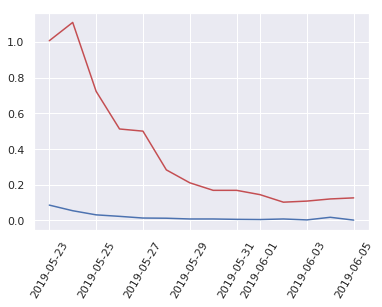

In [387]:
#我的收益 点击率
plt.plot(df_sy['日期'],df_sy['doc_count'],'r-',
         df_sy['日期'],df_sy['死doc_count'],'b-')
plt.xticks(rotation='60')

In [394]:
dsl = {
                'query': {'bool': {'must': [
                                            {'range': {'paytime': {'gte': '2019-05-24', 
                                                                   'lte': '2019-06-06', 
                                                                   'format': 'yyyy-MM-dd', 'time_zone': '+08:00'}}}, 
                                            {'terms':{'user_id': dead_list}},
                                            #{'terms':{'user_id': dead_list}},
                                            {'query_string': {'query': 'skutotal_price != 0'}},
                                            {'terms': {'order_status': ['confirmed',
                                                                        'done',
                                                                        'fulfilled']}},
                                            ]}},
                "aggs": {
                    "my_buckets": {
                        "composite": {
                            'size': 9999999,
                            "sources": [{'日期': {'date_histogram': {'field': 'paytime', 'interval': '1d', 'time_zone': '+00:00'}}}
                                ]}} }}
es_order = Elasticsearch(['http://172.18.198.27:9200/'], timeout=30)
res_order = es_order.search(index='es_order_table', doc_type='order', body=dsl,
                        _source=False, explain=False, track_scores=False, track_total_hits=False, size=0,
                        search_type='query_then_fetch')
df_order = json_normalize(res_order['aggregations']['my_buckets']['buckets'])
df_order.columns = map(lambda x: x.split('key.')[-1] if x.startswith('key.') else x, list(df_order.columns))
df_order['日期'] = df_order['日期'].apply(to_date)
df_order['日期'] = pd.to_datetime(df_order['日期'])
df_order['doc_count']=df_order['doc_count']/len(dead_list)

In [395]:
dsl = {
                'query': {'bool': {'must': [
                                            {'range': {'paytime': {'gte': '2019-05-24', 
                                                                   'lte': '2019-06-06', 
                                                                   'format': 'yyyy-MM-dd', 'time_zone': '+08:00'}}}, 
                                            #{'terms':{'user_id': dead_list}},
                                            {'terms':{'user_id': dead_list}},
                                            {'query_string': {'query': 'skutotal_price != 0'}},
                                            {'terms': {'order_status': ['confirmed',
                                                                        'done',
                                                                        'fulfilled']}},
                                            ]}},
                "aggs": {
                    "my_buckets": {
                        "composite": {
                            'size': 9999999,
                            "sources": [{'日期': {'date_histogram': {'field': 'paytime', 'interval': '1d', 'time_zone': '+00:00'}}}
                                ]}} }}
es_order2 = Elasticsearch(['http://172.18.198.27:9200/'], timeout=30)
res_order2 = es_order2.search(index='es_order_table', doc_type='order', body=dsl,
                        _source=False, explain=False, track_scores=False, track_total_hits=False, size=0,
                        search_type='query_then_fetch')
df_order2 = json_normalize(res_order2['aggregations']['my_buckets']['buckets'])
df_order2.columns = map(lambda x: x.split('key.')[-1] if x.startswith('key.') else x, list(df_order2.columns))
df_order2['日期'] = df_order2['日期'].apply(to_date)
df_order2['日期'] = pd.to_datetime(df_order2['日期'])
df_order2['doc_count']=df_order2['doc_count']/len(active_list)
df_order['活doc_count']=df_order2['doc_count']
df_order.head()

,doc_count,日期,活doc_count
0,0.266527,2019-05-23,1.530120
1,0.163694,2019-05-24,0.939759
2,0.103882,2019-05-25,0.596386
3,0.093389,2019-05-26,0.536145
4,0.103882,2019-05-27,0.596386


(array([737202., 737204., 737206., 737208., 737210., 737211., 737213.,
        737215.]), <a list of 8 Text xticklabel objects>)

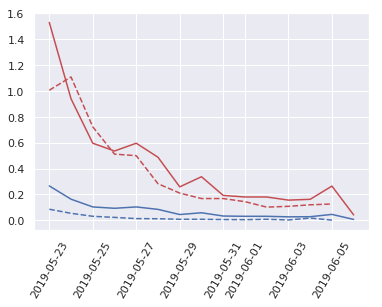

In [398]:
#下单率
plt.plot(df_order['日期'],df_order['doc_count'],'b-',    #人均订单
         df_order['日期'],df_order['活doc_count'],'r-',
         df_sy['日期'],df_sy['doc_count'],'r--',      #我的收益点击率
         df_sy['日期'],df_sy['死doc_count'],'b--'
        )
plt.xticks(rotation='60')

In [417]:
dsl = {'aggs': {'my_buckets': {'composite': {'size': 9999999,'sources': [
                                                   {'id': {'terms': {'field': 'id'}}},
                                                 ]}}},
      'query': {'bool': {'must': [{'terms':{'user_parent_list':active_list}}
                            ]}}}
es_market = Elasticsearch(['http://172.18.198.27:9200/'], timeout=30)
res_market = es_market.search(index='es_user_table', doc_type='user', body=dsl,
                        _source=False, explain=False, track_scores=False, track_total_hits=False, size=0,
                        search_type='query_then_fetch')
df_market = json_normalize(res_market['aggregations']['my_buckets']['buckets'])
df_market.columns = map(lambda x: x.split('key.')[-1] if x.startswith('key.') else x, list(df_market.columns))

In [422]:
df_market['id'].nunique()/len(active_list)

8.168674698795181

In [418]:
dsl = {'aggs': {'my_buckets': {'composite': {'size': 9999999,'sources': [
                                                   {'id': {'terms': {'field': 'id'}}},
                                                 ]}}},
      'query': {'bool': {'must': [{'terms':{'user_parent_list':dead_list}}
                            ]}}}
es_market2 = Elasticsearch(['http://172.18.198.27:9200/'], timeout=30)
res_market2 = es_market2.search(index='es_user_table', doc_type='user', body=dsl,
                        _source=False, explain=False, track_scores=False, track_total_hits=False, size=0,
                        search_type='query_then_fetch')
df_market2 = json_normalize(res_market2['aggregations']['my_buckets']['buckets'])
df_market2.columns = map(lambda x: x.split('key.')[-1] if x.startswith('key.') else x, list(df_market2.columns))

In [423]:
df_market2['id'].nunique()/len(dead_list)

0.4438614900314795

In [472]:
dsl = {'query': {'bool': {'must': 
                                    [#{'range': {'created': {'gte': '2019-05-24', 
                                     #                       'lte': '2019-06-06', 
                                     #                       'format': 'yyyy-MM-dd', 'time_zone': '+08:00'}}}, 
                                        {'terms':{'user_id': active_list}},
                                        #{'terms':{'user_id': dead_list}},
                                        #{'terms': {'event_name': ['我的收益']}}
                                    ]}}, 
         'aggs': {'my_buckets': {'composite': {'size': 9999999, 'sources': [{'人': {'terms': {'field': 'user_id'}}},
                                                   {'场景': {'terms': {'field': 'session_scene'}}},
                                                    
                                                                           ]}, 
                                }}}
es_fx = Elasticsearch(['http://172.18.198.27:9200/'], timeout=30)
res_fx = es_fx.search(index='shop_pv_event', doc_type='pv_event', body=dsl,
                _source=False, explain=False, track_scores=False, track_total_hits=False, size=0,
                search_type='query_then_fetch')
df_fx = json_normalize(res_fx['aggregations']['my_buckets']['buckets'])
df_fx.columns = map(lambda x: x.split('key.')[-1] if x.startswith('key.') else x, list(df_fx.columns))
df_active_list=df_fx['场景'].value_counts()
df_form_active=pd.DataFrame(df_active_list)
df_form_active.head()
active_per=df_form_active['场景']/len(active_list)
df_form_active['百分比']=active_per
df_form_active

,场景,百分比
1089,121,0.728916
1011,91,0.548193
1047,72,0.433735
1048,55,0.331325
1014,54,0.325301
1001,53,0.319277
1007,41,0.246988
1008,36,0.216867
1027,19,0.114458
,11,0.066265


In [473]:
dsl = {'query': {'bool': {'must': 
                                    [#{'range': {'created': {'gte': '2019-05-24', 
                                     #                       'lte': '2019-06-06', 
                                     #                       'format': 'yyyy-MM-dd', 'time_zone': '+08:00'}}}, 
                                        #{'terms':{'user_id': active_list}},
                                        {'terms':{'user_id': dead_list}},
                                        #{'terms': {'event_name': ['我的收益']}}
                                    ]}}, 
         'aggs': {'my_buckets': {'composite': {'size': 9999999, 'sources': [{'人': {'terms': {'field': 'user_id'}}},
                                                   {'场景': {'terms': {'field': 'session_scene'}}},
                                                     ]}, 
                                }}}
es_fx = Elasticsearch(['http://172.18.198.27:9200/'], timeout=30)
res_fx = es_fx.search(index='shop_pv_event', doc_type='pv_event', body=dsl,
                _source=False, explain=False, track_scores=False, track_total_hits=False, size=0,
                search_type='query_then_fetch')
df_fx = json_normalize(res_fx['aggregations']['my_buckets']['buckets'])
df_fx.columns = map(lambda x: x.split('key.')[-1] if x.startswith('key.') else x, list(df_fx.columns))
df_dead_list=df_fx['场景'].value_counts()
pd.DataFrame(df_dead_list).to_csv('死亡用户场景.csv')
df_form_dead=pd.DataFrame(df_dead_list)
dead_per=df_form_dead['场景']/len(dead_list)
df_form_dead['百分比']=dead_per
df_form_dead

,场景,百分比
1047,507,0.532004
1011,439,0.460651
1089,402,0.421826
1048,242,0.253935
1014,181,0.189927
1001,175,0.183631
1007,151,0.158447
1008,88,0.092340
1027,75,0.078699
,68,0.071354
